# ESRGAN inference

## Setup

In [1]:
# Get ESRGAN-pytorch
! git clone https://github.com/qAp/ESRGAN-pytorch.git
%cd ESRGAN-pytorch/
! git checkout -b distributed remotes/origin/distributed
! pip install --editable .
%cd ../.

Cloning into 'ESRGAN-pytorch'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 889 (delta 15), reused 21 (delta 6), pack-reused 854
Receiving objects: 100% (889/889), 257.20 MiB | 20.03 MiB/s, done.
Resolving deltas: 100% (511/511), done.
/content/ESRGAN-pytorch
Branch 'distributed' set up to track remote branch 'distributed' from 'origin'.
Switched to a new branch 'distributed'
Obtaining file:///content/ESRGAN-pytorch
  Running setup.py develop for ESRGAN-pytorch-qap
/content


In [1]:
from google.colab import drive
import os, sys, subprocess, shutil
from pathlib import Path
from collections import OrderedDict
import PIL, cv2
import numpy as np, itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torchvision.utils import save_image
import torchvision.transforms.functional as TF
from ESRGAN_pytorch.model.ESRGAN import ESRGAN
from ESRGAN_pytorch.datasets.preparation.make_patches import crop_image

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def _cp(src, dst):
    assert src.is_file()
    shutil.copy(src, dst)
    
Path.cp = _cp
Path.ls = lambda o: list(o.iterdir())

In [4]:
dir_gdrive = Path('/content/drive/My Drive')

## Usefuls

In [ ]:
def get_same_view(img_hr, img_lr, b0_hr=None, b1_hr=None):
    '''
    Grab the same corresponding area from the high and low
    resolution images.

    `img_hr`: np.array
        High resolution image.
    `img_lr`: np.array
        Low resolution image.
    `b0_hr`: tuple
        Lower and upper index to subsection dimension 0 
        of high resolution image.
    `b1_hr`: tuple
        Lower and upper index to subsection dimension 1 
        of high resolution image.
    '''
    if b0_hr is None: 
        b0_hr = (0, img_hr.shape[0])
    if b1_hr is None: 
        b1_hr = (0, img_hr.shape[1])
    for b, l in zip((b0_hr, b1_hr), img_hr.shape[:2]):
        assert 0 <= b[0] < b[1] <= l
    assert img_hr.shape[0]//img_lr.shape[0] == img_hr.shape[1]//img_lr.shape[1]
    scale = img_hr.shape[0]//img_lr.shape[0]
    b0_lr = tuple(l//scale for l in b0_hr)
    b1_lr = tuple(l//scale for l in b1_hr)
    img_hr_ = img_hr[slice(*b0_hr),slice(*b1_hr)]
    img_lr_ = img_lr[slice(*b0_lr),slice(*b1_lr)]
    return img_hr_, img_lr_

## Data

In [162]:
def test_image_fns_singapore():
    ! cp -r /content/drive/My\ Drive/tiles_-_singapore_main_sz512.zip .
    ! unzip -o tiles_-_singapore_main_sz512.zip
    dir_sg = Path('tiles_-_singapore_main_sz512/')
    imgids_test = ['400_8800', '1200_8000', '4800_2400', '5200_16400', 
                   '6000_8400', '0_7600', '1600_6400', '1600_11200',
                   '11200_9200']
    fns = [dir_sg/f'main_{imgid}.jpeg' for imgid in imgids_test]
    return fns

In [24]:
def test_image_fns_wellington():
    ! cp /content/drive/My\ Drive/lds-wellington-010m-urban-aerial-photos-2017-JPEG-20200805T075359Z-003.zip .
    ! unzip lds-wellington-010m-urban-aerial-photos-2017-JPEG-20200805T075359Z-003.zip

    dir_src = Path('lds-wellington-010m-urban-aerial-photos-2017-JPEG')

    fns = ['BQ31_500_022084']
    fns = [dir_src/f'{fn}.jpg' for fn in fns]
    return fns

In [25]:
def test_image_fns_spacenet():
    ! cp /content/drive/My\ Drive/mixed_big.zip .
    ! unzip mixed_big.zip
    dir_src = Path('mixed_big')
    fns = ['vegas_453', 'khartoum_627']
    fns = [dir_src/f'{fn}.jpeg' for fn in fns]
    return fns

In [163]:
fns = test_image_fns_singapore()

Archive:  tiles_-_singapore_main_sz512.zip
  inflating: tiles_-_singapore_main_sz512/main_17600_16800.jpeg  
  inflating: tiles_-_singapore_main_sz512/main_2000_8000.jpeg  
  inflating: tiles_-_singapore_main_sz512/main_0_9600.jpeg  
  inflating: tiles_-_singapore_main_sz512/main_10000_16400.jpeg  
  inflating: tiles_-_singapore_main_sz512/main_18800_7600.jpeg  
  inflating: tiles_-_singapore_main_sz512/main_10800_10800.jpeg  
  inflating: tiles_-_singapore_main_sz512/main_16800_14000.jpeg  
  inflating: tiles_-_singapore_main_sz512/main_7200_3600.jpeg  
  inflating: tiles_-_singapore_main_sz512/main_6400_2800.jpeg  
  inflating: tiles_-_singapore_main_sz512/main_15600_9600.jpeg  
  inflating: tiles_-_singapore_main_sz512/main_11600_10800.jpeg  
  inflating: tiles_-_singapore_main_sz512/main_4400_11200.jpeg  
  inflating: tiles_-_singapore_main_sz512/main_2400_12800.jpeg  
  inflating: tiles_-_singapore_main_sz512/main_18800_15200.jpeg  
  inflating: tiles_-_singapore_main_sz512/main_4

main_400_8800.jpeg


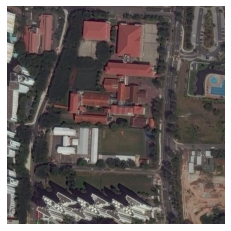

In [164]:
idx = 0
fn = fns[idx]
print(fn.name)
plt.imshow(np.array(PIL.Image.open(fn))); plt.axis('off');

In [165]:
dir_lr = Path('inference_lr'); dir_lr.mkdir(exist_ok=True)

In [166]:
for p in dir_lr.ls(): p.unlink()
for fn in fns: fn.cp(dir_lr/f'{fn.stem}.png')

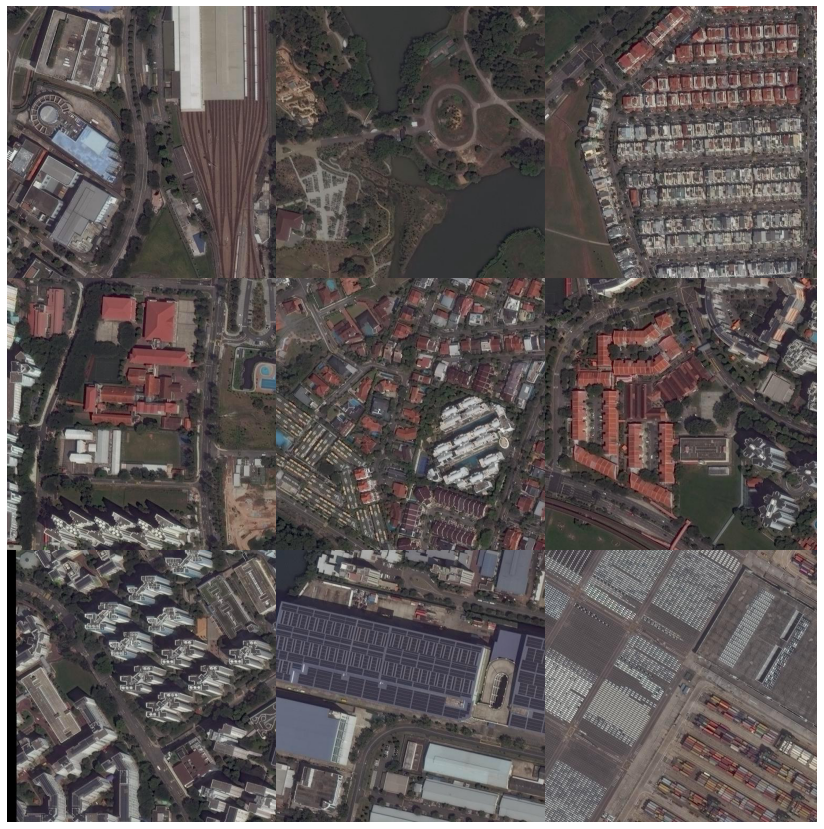

In [167]:
nimg = len(dir_lr.ls())
ncols = 3
nrows = (nimg - 1) // ncols + 1
plot_size = 5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                        figsize=(plot_size*ncols, plot_size*nrows))
axs = axs.flatten()
for ax, p in itertools.zip_longest(axs, dir_lr.ls()):
    ax.axis('off')
    if p:
        img = np.array(PIL.Image.open(p))
        ax.imshow(img)
    
fig.subplots_adjust(wspace=-.1, hspace=0)

### Crop images

In [168]:
sz, stride = 64, 50

In [169]:
crop_image(dir_lr, sz, stride)

[*] [0/9] Make patch inference_lr/main_6000_8400.png


In [170]:
len(dir_lr.ls())

576

## Inference

In [171]:
class Config:
    nodes = 1               # Number of nodes
    gpus = 1                # Number of GPUs per node
    nr = 0      # Node rank. If there're 2 nodes, possible node ranks are 0, 1.
    distributed = False  # Use distributed training.
    input_dir = 'datasets' # input directory, containing `hr` and `lr` directories
    load = ''  # Load model. (Default: none)
    resume = ''  # Resume model. (Default: none)
    image_size = 128  # the height / width of the input image to network
    batch_size = 16   # batch size
    sample_batch_size = 1 # sample batch size
    num_epoch = 20 # number of epochs to train for
    epoch = 0 # epochs in current train
    checkpoint_dir = 'checkpoints' # path to saved models (to continue training)
    sample_dir = 'samples' # folder to output images and model checkpoints
    workers = 5 # number of data loading workers
    scale_factor = 4 # scale factor for super resolution
    nf = 32 # number of filter in esrgan
    b1 = 0.9 # coefficients used for computing running averages of gradient and its square
    b2 = 0.999 # coefficients used for computing running averages of gradient and its square
    weight_decay = 1e-2 # weight decay
    p_lr = 2e-4 # learning rate when when training perceptual oriented
    p_decay_iter = [2e5, 2*2e5, 3*2e5, 4*2e5, 5*2e5] # Milestones of number 
    #  of mini-batches at which to halve the learning rate.
    p_content_loss_factor = 1 # content loss factor when training perceptual oriented
    p_perceptual_loss_factor = 0 # perceptual loss factor when training perceptual oriented
    p_adversarial_loss_factor = 0  # adversarial loss factor when training perceptual oriented
    g_lr = 1e-4 # learning rate when when training generator oriented
    g_decay_iter = [50000, 100000, 200000, 300000, 400000, 500000] 
    # Milestones of number of mini-batches at which to halve the learning rate.
    g_content_loss_factor = 1e-2 # content loss factor when training generator oriented
    g_perceptual_loss_factor = 1 # perceptual loss factor when training generator oriented
    g_adversarial_loss_factor = 5e-3 # adversarial loss factor when training generator oriented
    is_perceptual_oriented = True
    fp16 = False

    url = ['http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip',
           'http://cv.snu.ac.kr/research/EDSR/Flickr2K.tar'
           ]

    dataset_url = url # the url of DIV2K dataset for super resolution

In [172]:
# %load ~/git_repos/ESRGAN-pytorch/test.py
def get_interp_model(pth_gan='parameters/gan.pth', 
                     pth_psn='parameters/psnr.pth', alpha=0.8):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    sdict_psn = torch.load(pth_psn, map_location=device)['g_state_dict']
    sdict_gan = torch.load(pth_gan, map_location=device)['g_state_dict']
    sdict_psn = {k[7:] if k.startswith('module.') else k:v 
                 for k, v in sdict_psn.items()}
    sdict_gan = {k[7:] if k.startswith('module.') else k:v 
                 for k, v in sdict_gan.items()}
    sdict_avg = OrderedDict()
    for k, v_psn in sdict_psn.items():
        v_gan = sdict_gan[k]
        sdict_avg[k] = (1 - alpha) * v_psn + alpha * v_gan
    model = ESRGAN(3, 3, scale_factor=4)
    model.load_state_dict(sdict_avg)
    return model


def esrgan_inference(pth_gan='parameters/gan.pth', 
                     pth_psn='parameters/psnr.pth',
                     alpha=0.8, dir_lr=None, dir_sr=None):
    model = get_interp_model(pth_gan, pth_psn, alpha)
    if not os.path.exists(dir_lr): raise Exception('[!] No lr path')
    if not os.path.exists(dir_sr): os.makedirs(dir_sr)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        model = model.to(device).eval()
        for image_name in tqdm(os.listdir(dir_lr)):
            image = PIL.Image.open(os.path.join(dir_lr, image_name)).convert('RGB')
            image = TF.to_tensor(image).to(device).unsqueeze(dim=0)
            image = model(image)
            save_image(image,  os.path.join(dir_sr, image_name))

In [186]:
# dir_checkpoint = dir_gdrive/'esrgan_results'
# fn_psnr = dir_checkpoint/'exp17'/'best.pth'
# fn_gan = dir_checkpoint/'exp17'/'best.pth'

# dir_checkpoint = dir_gdrive/'esrgan_results'
# fn_psnr = dir_checkpoint/'exp17'/'last.pth'
# fn_gan = dir_checkpoint/'exp17'/'last.pth'

# Pre-trained
dir_checkpoint = Path('ESRGAN-pytorch/')/'parameters'
fn_psnr = dir_checkpoint/'psnr_based.pth'
fn_gan = dir_checkpoint/'gan_based.pth'

In [187]:
dir_sr = Path('inference_sr_exp17'); dir_sr.mkdir(exist_ok=True)
for p in dir_sr.ls(): p.unlink()

In [188]:
esrgan_inference(pth_psn=fn_psnr, pth_gan=fn_gan, alpha=.8,
                 dir_lr=dir_lr, dir_sr=dir_sr)

100%|██████████| 576/576 [00:49<00:00, 11.57it/s]


## Look at the results

In [151]:
def show_results(imgs_lr, imgs_hr):
    assert len(imgs_lr)==len(imgs_hr)
    n = len(imgs_lr)
    ncols = 5
    nrows = 2 * ((n - 1) // ncols + 1)
    plot_size = 5

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                            figsize=(plot_size * ncols, plot_size * nrows))
    for line in axs:
        for ax in line: 
            ax.axis('off'); ax.margins(0, 0)

    for i, (lr, hr) in enumerate(zip(imgs_lr, imgs_hr)):
        axs[2*(i//ncols), i % ncols].imshow(lr)
        axs[2*(i//ncols) + 1, i % ncols].imshow(hr)

    fig.subplots_adjust(wspace=0, hspace=0)
    return fig

In [176]:
# fns_lr = np.random.choice(dir_lr.ls(), size=100, replace=False)

In [189]:
fns_sr = [dir_sr/p.name for p in fns_lr]
imgs_lr = [np.array(PIL.Image.open(p)) for p in fns_lr]
imgs_sr = [np.array(PIL.Image.open(p)) for p in fns_sr]

In [190]:
fig = show_results(imgs_lr, imgs_sr)

Output hidden; open in https://colab.research.google.com to view.

In [191]:
fig.savefig(dir_gdrive/'esrgan_results'/'inference'/f'sr_singapore_using_pretrained.png')

In [89]:
(dir_gdrive/'esrgan_results'/'inference').ls()

[PosixPath('/content/drive/My Drive/esrgan_results/inference/sr_spacenet_using_pretrained.png'),
 PosixPath('/content/drive/My Drive/esrgan_results/inference/sr_spacenet_using_exp17.png'),
 PosixPath('/content/drive/My Drive/esrgan_results/inference/sr_singapore_using_pretrained.png'),
 PosixPath('/content/drive/My Drive/esrgan_results/inference/sr_singapore_using_exp17.png'),
 PosixPath('/content/drive/My Drive/esrgan_results/inference/sr_singapore_using_exp17_bgr.png'),
 PosixPath('/content/drive/My Drive/esrgan_results/inference/sr_nz_using_exp17.png'),
 PosixPath('/content/drive/My Drive/esrgan_results/inference/sr_nz_using_pretrained.png'),
 PosixPath('/content/drive/My Drive/esrgan_results/inference/sr_singapore_using_exp17last.png'),
 PosixPath('/content/drive/My Drive/esrgan_results/inference/sr_nz_using_exp17last.png'),
 PosixPath('/content/drive/My Drive/esrgan_results/inference/sr_nz_using_exp17best.png'),
 PosixPath('/content/drive/My Drive/esrgan_results/inference/sr_singa

# Look at training output

In [ ]:
fn_best = dir_gdrive/'esrgan_results'/'exp17'/'last.pth'

In [ ]:
sdict = torch.load(fn_best)

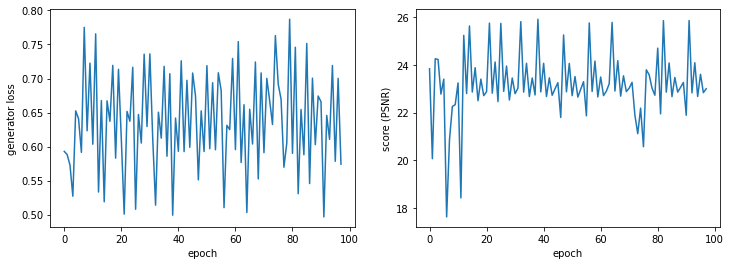

In [ ]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs[0].plot(sdict['history']['generator_loss'])
axs[0].set_ylabel('generator loss')
axs[0].set_xlabel('epoch');
axs[1].plot(sdict['history']['score'])
axs[1].set_ylabel('score (PSNR)')
axs[1].set_xlabel('epoch');

In [ ]:
sdict['opt_g_state_dict']['param_groups'][0]['lr']

6.25e-06